In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("audit_risk.csv")

In [3]:
dataset.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [4]:
dataset["Risk"].value_counts()

0    471
1    305
Name: Risk, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f601b8af9b0>,
      dtype=object)

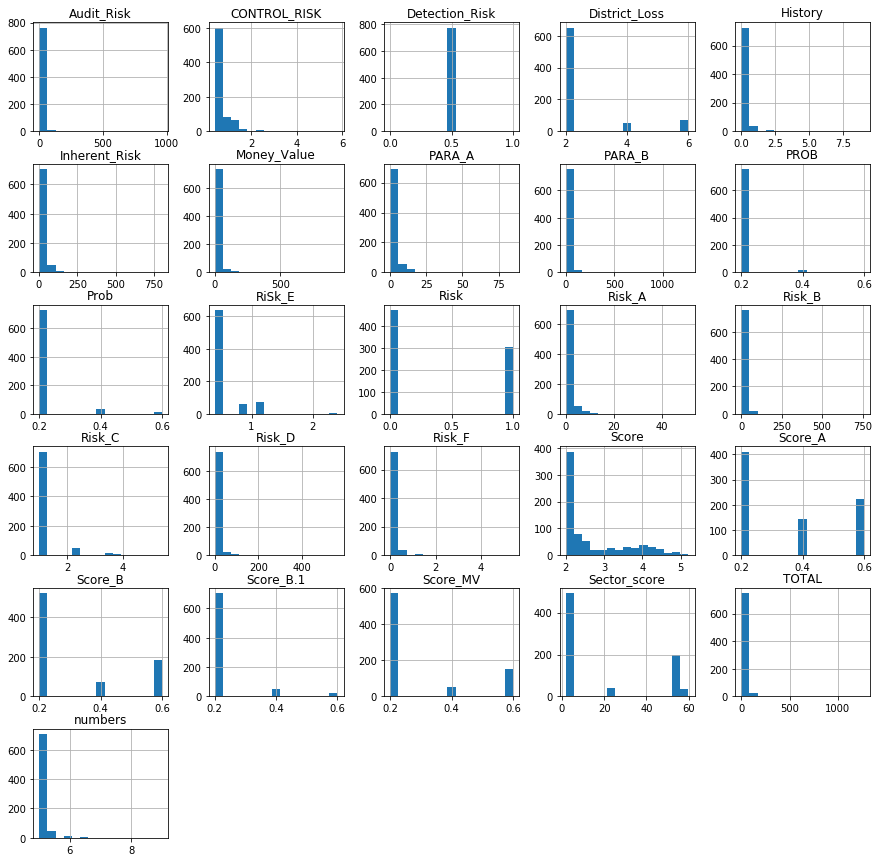

In [5]:
dataset.hist(bins=15, figsize=(15, 15))

In [6]:
corr_matrix = dataset.corr()
corr_matrix["Risk"].sort_values(ascending=False)

Risk              1.000000
Score             0.785995
Score_MV          0.688367
Score_B           0.635768
Score_A           0.619726
CONTROL_RISK      0.416474
RiSk_E            0.411803
District_Loss     0.403806
Risk_A            0.385067
PARA_A            0.378758
Inherent_Risk     0.357020
Score_B.1         0.353803
Risk_C            0.342140
numbers           0.308141
Prob              0.298639
TOTAL             0.292022
PARA_B            0.257029
Money_Value       0.256992
Risk_B            0.255286
Risk_D            0.254355
History           0.239453
Audit_Risk        0.217113
Risk_F            0.214511
PROB              0.176912
Sector_score     -0.394131
Detection_Risk         NaN
Name: Risk, dtype: float64

In [7]:
train_attr = ["Score", "Score_MV", "Score_B", "Score_A", "CONTROL_RISK", "RiSk_E", "District_Loss", "Risk_A",
              "PARA_A", "Inherent_Risk", "Score_B.1", "Risk_C", "numbers", "Sector_score"]

X_data = dataset[train_attr].values
m, n = X_data.shape

y_data = dataset.iloc[:, -1].values

In [8]:
n_inputs = n
n_hidden1 = 115
n_hidden2 = 45
n_outputs = 2

In [9]:
test_ratio = 0.2
test_size = int(m*test_ratio)
train_size = m - test_size

X_train = X_data[:-test_size]
X_test = X_data[-test_size:]
y_train = y_data[:-test_size]
y_test = y_data[-test_size:]

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
import tensorflow as tf

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int32, shape=(None))

In [12]:
threshold = 1.0

def max_norm_regularizer(threshold, axes=1, collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped)
        tf.add_to_collection(collection, clip_weights)
        return None
    return max_norm

In [13]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, kernel_regularizer=max_norm_reg)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, kernel_regularizer=max_norm_reg)
logits = tf.layers.dense(hidden2, n_outputs)

In [14]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

In [15]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [16]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()

In [23]:
n_epochs = 25
batch_size = 35
n_batches = int(np.ceil(m/batch_size))

In [19]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * batch_index + batch_size)
    indices = np.random.randint(train_size, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

In [24]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
            
        train_acc_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        test_acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
            
        print("Epoch:", epoch, "Train Acc: {:.3f}".format(100*train_acc_val), 
                               "Test Acc: {:.3f}".format(100*test_acc_val))

Epoch: 0 Train Acc: 100.000 Test Acc: 96.129
Epoch: 1 Train Acc: 97.143 Test Acc: 98.710
Epoch: 2 Train Acc: 100.000 Test Acc: 98.710
Epoch: 3 Train Acc: 97.143 Test Acc: 98.710
Epoch: 4 Train Acc: 100.000 Test Acc: 98.710
Epoch: 5 Train Acc: 97.143 Test Acc: 98.710
Epoch: 6 Train Acc: 97.143 Test Acc: 98.710
Epoch: 7 Train Acc: 100.000 Test Acc: 98.710
Epoch: 8 Train Acc: 100.000 Test Acc: 97.419
Epoch: 9 Train Acc: 100.000 Test Acc: 98.710
Epoch: 10 Train Acc: 100.000 Test Acc: 98.710
Epoch: 11 Train Acc: 100.000 Test Acc: 98.065
Epoch: 12 Train Acc: 94.286 Test Acc: 98.710
Epoch: 13 Train Acc: 100.000 Test Acc: 98.065
Epoch: 14 Train Acc: 100.000 Test Acc: 98.710
Epoch: 15 Train Acc: 94.286 Test Acc: 98.065
Epoch: 16 Train Acc: 97.143 Test Acc: 90.968
Epoch: 17 Train Acc: 100.000 Test Acc: 97.419
Epoch: 18 Train Acc: 100.000 Test Acc: 98.710
Epoch: 19 Train Acc: 97.143 Test Acc: 98.710
Epoch: 20 Train Acc: 97.143 Test Acc: 98.710
Epoch: 21 Train Acc: 91.429 Test Acc: 98.710
Epoch: 2